## Import modules

In [1]:
import tensorflow
import tensorflow.keras
import tensorflow.keras.callbacks as CB
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, ReLU, Input, MaxPooling1D
from tensorflow.keras.models import Sequential

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size': 14})

/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorf

## LOAD DATABASES, CONCATENATE AND MIX THEM

In [5]:
rv = [10,20,30,40,50,60]
nr = len(rv)



def load_and_shuffle_dbs(rv):
    paths = []
    for r in rv:
        paths.append(f"/scratch/scarpolini/databases/db_lorenz_{r:.1f}.npy")
    
    n_traj = 50000
    db = np.ndarray(shape=(len(rv)*n_traj,2000,1))
    labels = []
    for path,r,i in zip(paths,rv,range(nr)):
        db1 = np.load(path)
        for j in range(n_traj):
            db[i*n_traj + j,:,0] = db1[j,0,:]
            labels.append(r)
    
    labels = np.array(labels)
    
    def unison_shuffled_copies(a, b):
        #print(f'len a {len(a)} len b {len(b)}')
        assert len(a) == len(b)
        p = np.random.permutation(len(a))
        return a[p], b[p]
    
    db, labels = unison_shuffled_copies(db, labels)
    return db, labels




#db, labels = load_and_shuffle_dbs(rv)
#
#rv_test = [15,25,35,45,55]
#db_test, labels_test = load_and_shuffle_dbs(rv_test)
#db_test = db_test[:5000]
#labels_test = labels_test[:5000]

## CONVERTO LABELS PER DEFINIRE LE CLASSI

In [6]:
lM = 60.
lm = 10.
def norm_labels(labels):
    return (labels - lm)/(lM - lm)

def denorm_labels(labels):
    return labels * (lM - lm) + lm

#labels = norm_labels(labels)
#labels_test = norm_labels(labels_test)

## PREPROCESSING

In [7]:
def preprocess(db):
    db = db[:,:,0:1]
    #print(db.shape)
    M = np.max(db)
    m = np.min(db)
    #print(f'actual max and min: {M:.2f} and {m:.2f}')
    M = 33.45311378674468 # max and min among 10 20 30 40 50 60 databases
    m = -33.45763272036239
    #print(M,m)
    db = (db - m)/(M - m)
    M = np.max(db)
    m = np.min(db)
    #print(M,m)
    return db

#db = preprocess(db)
#db_test = preprocess(db_test)

## VISUALIZE DATA

295015
0.4


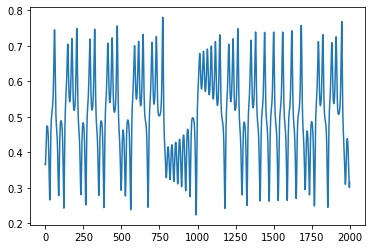

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
%matplotlib inline

n_traj = 50000
n = round(np.random.uniform(n_traj*nr))
#n = 35368
print(n)
traj = db[n,:,:]
print(labels[n])
plt.plot(traj[:,0])
#plt.plot(traj[:,1])
#plt.plot(traj[:,2])
plt.show()

#fig = plt.figure()
#ax = plt.axes(projection='3d')
#ax.plot3D(traj[:,0],traj[:,1],traj[:,2])

## ARCHITETTURA RETE NEURALE

In [30]:
#opt = Adam(0.0008)
opt = Adam(0.00008)
#opt = Adam(0.0008)
sig_len, channels = len(db[0,:,0]), len(db[0,0,:])
fs = 20 # dimensione filtro
fm = 16 # numero filtri
sigma_init = 0.02 # varianza distribuzione parametri iniziali dei kernel
mean_init = 0.
def create_desc():
    discriminator = Sequential()
    #2000x1
    discriminator.add(Conv1D(fm, fs, strides=8, padding='same', activation='relu', kernel_initializer=RandomNormal(mean_init, sigma_init), input_shape=(sig_len, channels)))    
    #250x8
    discriminator.add(Conv1D(fm, fs, strides=8, padding='same', activation='relu', kernel_initializer=RandomNormal(mean_init, sigma_init)))    
    #32x8
    discriminator.add(Conv1D(fm, fs, strides=4, padding='same', activation='relu', kernel_initializer=RandomNormal(mean_init, sigma_init))) 
    #8x8
    discriminator.add(Flatten())
    #64x1
    discriminator.add(Dense(8*fm, activation='relu'))
    #64x1
    discriminator.add(Dense(1, activation='relu'))
    #1x1
    discriminator.compile(loss='mse', optimizer=opt)
    return discriminator

desc = create_desc()
#opt = Adam(0.0008)
#desc.compile(loss='mse', optimizer=opt)


In [31]:
desc.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 250, 16)           336       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 32, 16)            5136      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 8, 16)             5136      
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 27,249
Trainable params: 27,249
Non-trainable params: 0
__________________________________________________

# TRAINING

In [45]:
class AdditionalValidationSets(CB.Callback):
    def __init__(self, validation_sets, e_list, verbose=0, batch_size=None):
        """
        :param validation_sets:
        a list of 3-tuples (validation_data, validation_targets, validation_set_name)
        or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        for validation_set in self.validation_sets:
            if len(validation_set) not in [2, 3]:
                raise ValueError()
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            if len(validation_set) == 3:
                validation_data, validation_targets, validation_set_name = validation_set
                sample_weights = None
            elif len(validation_set) == 4:
                validation_data, validation_targets, sample_weights, validation_set_name = validation_set
            else:
                raise ValueError()

            results = self.model.evaluate(x=validation_data,
                                          y=validation_targets,
                                          verbose=self.verbose,
                                          sample_weight=sample_weights,
                                          batch_size=self.batch_size)
            e_list.append(results)
            print(f" - val2_loss: {results:.4e}")
            #valuename = validation_set_name + '_loss'
            #self.history.setdefault(valuename, []).append(results)

            #for i, result in enumerate(results):
            #    if i == 0:
            #        valuename = validation_set_name + '_loss'
            #    else:
            #        valuename = validation_set_name + '_' + self.model.metrics[i-1].__name__
            #    self.history.setdefault(valuename, []).append(result)
                

                
                
                
                
                
                
                
                
e_list = []                
                
if db.shape[0] != 50000*6 and db_test.shape[0] != 5000*5:
    print("realoading training database")
    rv = [10,20,30,40,50,60]
    db, labels = load_and_shuffle_dbs(rv)
    labels = norm_labels(labels)
    db = preprocess(db)
    
    rv_test = [15,25,35,45,55]
    db_test, labels_test = load_and_shuffle_dbs(rv_test)
    db_test = db_test[:5000]
    labels_test = labels_test[:5000]
    labels_test = norm_labels(labels_test)
    db_test = preprocess(db_test)
    
my_callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=2),
    tensorflow.keras.callbacks.ModelCheckpoint(filepath='models/predictor_40_new.{epoch:02d}-{val_loss:.2g}.h5'),
    tensorflow.keras.callbacks.TensorBoard(log_dir='models/predictor_new_logs'),
    AdditionalValidationSets([(db_test, labels_test, 'val2')], e_list)
]
fit_history = desc.fit(db, labels, batch_size=500, epochs=20, verbose=1, validation_split=0.33,
                       shuffle=False, callbacks=my_callbacks)

Train on 200999 samples, validate on 99001 samples
Epoch 1/20
200999/200999 [==============================] - 5s 26us/sample - loss: 2.0271e-05 - val_loss: 3.0841e-05
Epoch 2/20
200999/200999 [==============================] - 5s 26us/sample - loss: 2.0121e-05 - val_loss: 1.9508e-05
Epoch 3/20
200999/200999 [==============================] - 6s 29us/sample - loss: 2.0070e-05 - val_loss: 1.7956e-05
Epoch 4/20
200999/200999 [==============================] - 6s 30us/sample - loss: 1.9876e-05 - val_loss: 1.7302e-05
Epoch 5/20
200999/200999 [==============================] - 6s 30us/sample - loss: 1.9574e-05 - val_loss: 1.7900e-05
Epoch 6/20
200999/200999 [==============================] - 6s 28us/sample - loss: 1.9362e-05 - val_loss: 1.9259e-05
Epoch 7/20
200999/200999 [==============================] - 6s 30us/sample - loss: 1.9181e-05 - val_loss: 1.9795e-05
Epoch 8/20
200999/200999 [==============================] - 6s 32us/sample - loss: 1.8995e-05 - val_loss: 2.1036e-05
Epoch 9/20
20

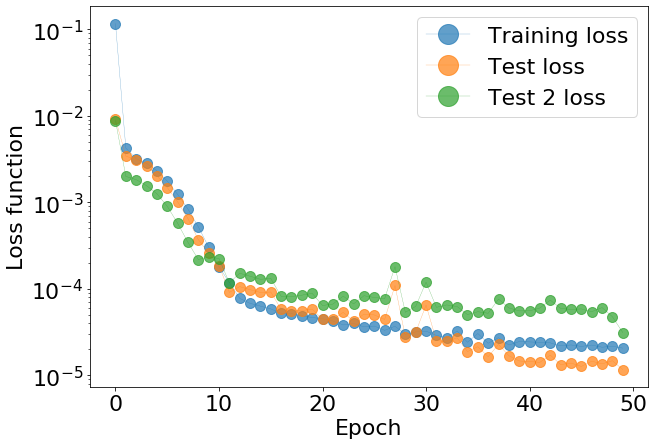

In [88]:
mpl.rcParams.update({'font.size': 22})
#epoch = fit_history.history
#with open('predictor_loss.dat','w') as f:
#    for i in range(len(epoch['loss'])):
#        f.write("%7d %13.7g %13.7g %13.7g\n"%(i,epoch['loss'][i],epoch['val_loss'][i],e_list[i]))

import matplotlib.pyplot as plt
loss = np.loadtxt('predictor_loss.dat')
loss = loss[:50]
plt.figure(figsize=(10,7))
plt.xlabel("Epoch")
plt.yscale('log')
plt.ylabel('Loss function')
plt.plot(loss[:,0],loss[:,1], label="Training loss", lw=0.3, marker='.',ms=20, alpha=0.7, markevery=1)
plt.plot(loss[:,0],loss[:,2], label="Test loss", lw=0.3, marker='.',ms=20, alpha=0.7, markevery=1)
plt.plot(loss[:,0],loss[:,3], label="Test 2 loss", lw=0.3, marker='.',ms=20, alpha=0.7, markevery=1)
plt.yscale('log')
plt.legend(markerscale=2)
plt.savefig(f'plots/training_plot.png', dpi=100, fmt='png')

In [2]:
# desc.save('models/predictor_10_20_30_40_50_60.h5')
from tensorflow.keras.models import load_model
desc = load_model('models/predictor_10_20_30_40_50_60.h5')

W0623 00:20:02.045121 46956875869696 deprecation.py:506] From /usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/keras/initializers.py:143: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0623 00:20:02.047986 46956875869696 deprecation.py:506] From /usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0623 00:20:02.189734 46956875869696 deprecation.py:506] From /usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__i

In [21]:
print(desc.test_on_batch(db,labels))

3.332643e-06


# TESTING

predicted r=[15]
predicted r=[25]
predicted r=[35]
predicted r=[45]
predicted r=[55]


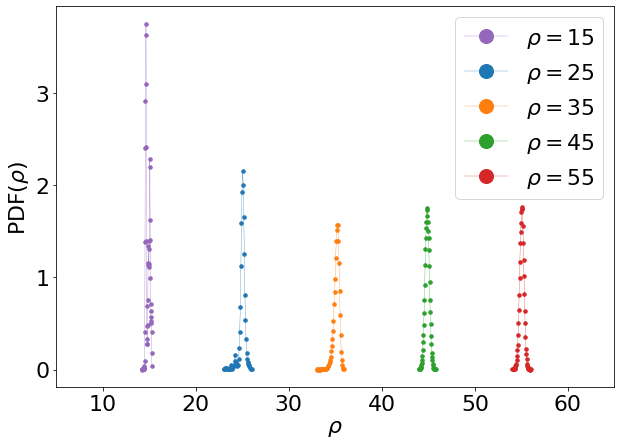

In [54]:
def load_dbs(rv):
    paths = []
    for r in rv:
        paths.append(f"/scratch/scarpolini/databases/db_lorenz_{r:.1f}.npy")
    n_traj = 50000
    db = np.ndarray(shape=(len(rv)*n_traj,2000,1))
    labels = []
    for path,r,i in zip(paths,rv,range(len(rv))):
        db1 = np.load(path)
        for j in range(n_traj):
            db[i*n_traj + j,:,0] = db1[j,0,:]
            labels.append(r)  
    labels = np.array(labels)
    return db, labels

def test_prep(rv):
    db, labels = load_dbs(rv)
    labels = norm_labels(labels)
    db = preprocess(db)
    return db, labels

import matplotlib as mpl
mpl.rcParams.update({'font.size': 22})
binsi = [np.arange(a,b,0.01) for a,b in zip([14,22,32,42,52],[16,28,38,48,58])]
rv = [[15],[25],[35],[45],[55]]
#rv = [[10],[20],[30],[40],[50],[60]]
ii = 0
plt.figure(figsize=(10,7))
colors = ['C4', 'C0', 'C1', 'C2', 'C3']
preds = []
for ii, r in enumerate(rv):
    db, labels = test_prep(r)
    aaa = desc.predict(db)
    print(f'predicted r={r}')
    bbb = denorm_labels(aaa)
    hist, bin_edges = np.histogram(bbb, density=True, bins=50)
    for i in range(len(hist)):
        bin_edges[i] = (bin_edges[i]+bin_edges[i+1])/2.
    bin_edges = bin_edges[:-1]
    preds.append([hist,bin_edges])
    plt.plot(bin_edges, hist, label='$\\rho=$'+str(r[0]), alpha=1, marker='.', lw=0.3, ms=7, color=colors[ii])
    ii += 1
    
plt.legend(markerscale=4)
plt.xlabel('$\\rho$')
plt.xlim([5,65])
#plt.ylim([0,2])
plt.ylabel('PDF($\\rho$)')
#plt.ylim([0,4])
plt.savefig('plots/NN_predictions_new',fmt='png',dpi=100)
plt.show()

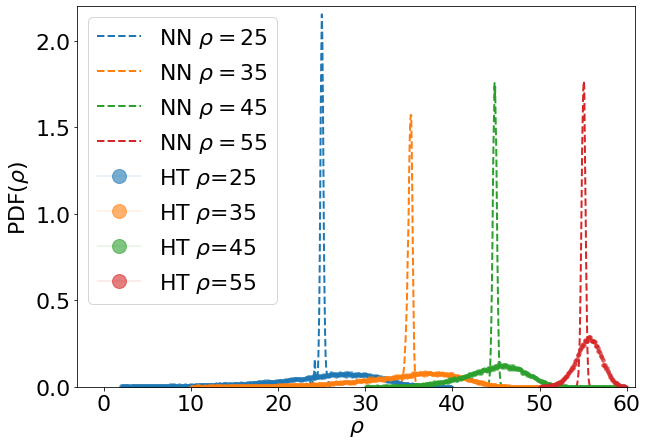

In [85]:
# NN predictions

import matplotlib as mpl
mpl.rcParams.update({'font.size': 22})
binsi = [np.arange(a,b,0.01) for a,b in zip([14,22,32,42,52],[16,28,38,48,58])]
rv = [15,25,35,45,55]
#rv = [[10],[20],[30],[40],[50],[60]]
ii = 0
plt.figure(figsize=(10,7))
colors = ['C4', 'C0', 'C1', 'C2', 'C3']
for ii in range(1,len(rv)):
    plt.plot(preds[ii][1], preds[ii][0], label='NN $\\rho=$'+str(rv[ii]), alpha=1, linestyle='dashed', lw=2, color=colors[ii])
    ii += 1
    

    
    
    
    
    
    
# Halving time predictions
    
def inversa(y):
    return (1./-0.10552)*y - 12.73180/-0.10552

rvn = [25,35,45,55]
labelsn = ['HT $\\rho$='+str(r) for r in rvn]
ii = 0
binsi = [np.arange(a,b,0.08) for a,b in zip([2,10,30,50],[40,50,60,60])]
for r, label in zip(rvn, labelsn):
    path = f'/scratch/scarpolini/databases/exit_time_{0.5:.2f}_lorenz_{r:.1f}.npy'
    et = np.load(path)
    previsione = inversa(et[0])
    hist, bin_edges = np.histogram(previsione, bins=binsi[ii], density=True)
    for i in range(len(hist)):
        bin_edges[i] = (bin_edges[i]+bin_edges[i+1])/2.
    bin_edges = bin_edges[:-1]
    plt.plot(bin_edges, hist, alpha=0.6, label=label, marker='.', lw=0.3, ms=7, color=colors[ii+1])
    ii += 1
    
    
    
    
    
    
    
    
    
plt.legend(markerscale=4)
plt.xlabel('$\\rho$')
plt.xlim([-3,61])
plt.ylim([0,2.2])
plt.ylabel('PDF($\\rho$)')
plt.savefig('plots/NN_and_HT_predictions_new',fmt='png',dpi=100)
plt.show()

# mean and std plot for some r

In [39]:
def test_prep(rv):
    db, labels = load_and_shuffle_dbs(rv)
    labels = norm_labels(labels)
    db = preprocess(db)
    return db, labels

rv = np.arange(10,61,1)
#rv = [15,25,35,45,55]
rv = [[r] for r in rv]
rr = []
mm = []
ss = []
for r in rv:
#    try:
    db, labels = test_prep(r)
    aaa = desc.predict(db)
    bbb = denorm_labels(aaa)
    
    a = []
    for aa in bbb:
        a.append(aa[0])
    bbb_mean = np.mean(a)
    bbb_std = np.std(a)
    print(f'$\\rho=${r[0]:.1f}: {bbb_mean:.2f}+-{bbb_std:.2f}')
    rr.append(r[0])
    mm.append(bbb_mean)
    ss.append(bbb_std)

$\rho=$10.0: 10.00+-0.00
$\rho=$11.0: 10.38+-0.38
$\rho=$12.0: 11.25+-0.59
$\rho=$13.0: 12.46+-0.44
$\rho=$14.0: 13.64+-0.30
$\rho=$15.0: 14.81+-0.21
$\rho=$16.0: 15.98+-0.16
$\rho=$17.0: 17.13+-0.12
$\rho=$18.0: 18.28+-0.12
$\rho=$19.0: 19.28+-0.13
$\rho=$20.0: 20.04+-0.13
$\rho=$21.0: 20.87+-0.19
$\rho=$22.0: 21.81+-0.29
$\rho=$23.0: 22.85+-0.35
$\rho=$24.0: 23.95+-0.35
$\rho=$25.0: 25.01+-0.30
$\rho=$26.0: 26.07+-0.24
$\rho=$27.0: 27.08+-0.20
$\rho=$28.0: 28.08+-0.17
$\rho=$29.0: 29.07+-0.16
$\rho=$30.0: 30.00+-0.15
$\rho=$31.0: 30.97+-0.18
$\rho=$32.0: 32.00+-0.20
$\rho=$33.0: 33.05+-0.24
$\rho=$34.0: 34.11+-0.27
$\rho=$35.0: 35.13+-0.28
$\rho=$36.0: 36.17+-0.26
$\rho=$37.0: 37.16+-0.24
$\rho=$38.0: 38.11+-0.22
$\rho=$39.0: 39.06+-0.20
$\rho=$40.0: 40.00+-0.20
$\rho=$41.0: 40.95+-0.22
$\rho=$42.0: 41.91+-0.21
$\rho=$43.0: 42.88+-0.21
$\rho=$44.0: 43.87+-0.22
$\rho=$45.0: 44.87+-0.23
$\rho=$46.0: 45.91+-0.23
$\rho=$47.0: 46.96+-0.23
$\rho=$48.0: 47.95+-0.23
$\rho=$49.0: 48.99+-0.20


/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  app.launch_new_instance()


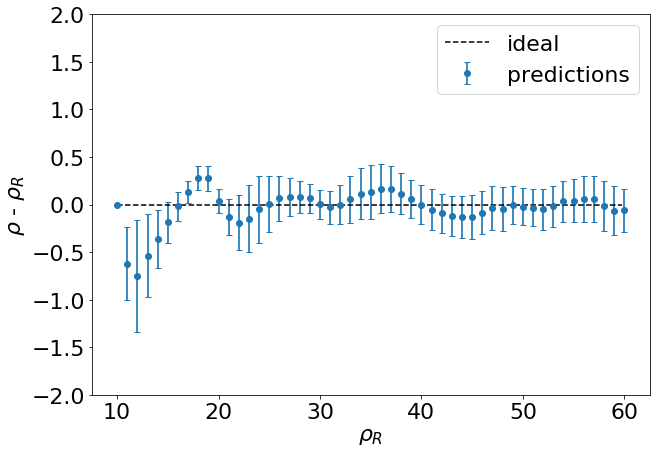

In [51]:
plt.figure(figsize=(10,7))
# scatter normalized around zero
xx = np.arange(10,60,0.3)
l, caps, c = plt.errorbar(rr, mm - np.array(rr), ss, lw=0, marker='o', ms=6, elinewidth=1.7, uplims=True, lolims=True, label='predictions')
for cap in caps:
    cap.set_marker("_")
plt.plot(xx, [0.]*len(xx), c='black', label='ideal', linestyle='dashed')
plt.xlabel('$\\rho_R$')
plt.ylabel('$\\rho$ - $\\rho_R$')
plt.ylim([-2,2])
plt.legend()

plt.savefig(f'plots/scatterplot_predictor.png', dpi=100, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format="png",
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)

# Test for GAN

### plot of pdf for a single value of r

/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  


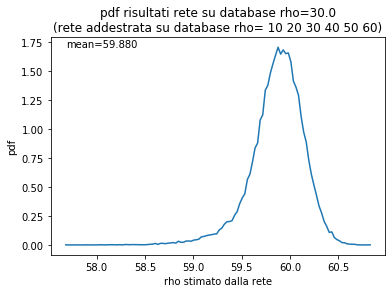

In [76]:
import matplotlib.pyplot as plt
rv = [30.]
nr = len(rv)
if nr == 1 :
    hist, bins = np.histogram(bbb,bins=120, density=True)
    plt.title(f'pdf risultati rete su database rho={rv[0]}\n(rete addestrata su database rho= 10 20 30 40 50 60)')
    plt.xlabel('rho stimato dalla rete')
    plt.ylabel('pdf')
    plt.plot(bins[:-1],hist)
    plt.text(np.min(bins[:-1]),np.max(hist),f'mean={bbb_mean:.3f}')
    plt.savefig(f'plots/pdf_predictor_rho{rv[0]}.png', dpi=220, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches=None, pad_inches=0.1,
                frameon=None, metadata=None)
    plt.show()

# Analisi previsioni del modello con rete neurale

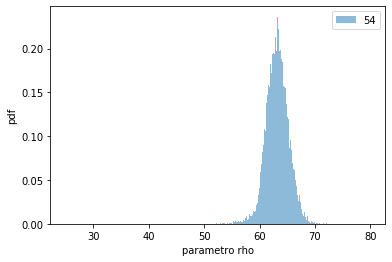

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def preprocess(db):
    db = db.reshape(-1,2000,1)
    M = np.max(db)
    m = np.min(db)
    M = 33.45311378674468 # max and min among 10 20 30 40 50 60 databases
    m = -33.45763272036239
    db = (db - m)/(M - m)
    M = np.max(db)
    m = np.min(db)
    return db

rv = [30, 40, 50, 60]
labels = ['r vero = '+str(r) for r in rv]
# paths = [f"/scratch/scarpolini/databases/db_lorenz_{r:.1f}.npy" for r in rv] #### vere
paths = [f"/scratch/scarpolini/lorenz_wgangp_new/runs/3/gen_trajs.npy"] #### generate
for path, label in zip(paths,labels):
    # db = np.load(path)[:,0:1,:] #### vere
    db = np.load(path)[:,:,0:1] #### generate
    # db = preprocess(db) #### vere
    previsione = denorm_labels(desc.predict(db))
    plt.hist(previsione, bins=np.arange(25,80,0.05), density=True, alpha=0.5, label=str(54))

plt.legend()
plt.xlabel('parametro rho')
plt.ylabel('pdf')
plt.legend()
plt.savefig("plots/pdf_NN_predictions_training_rho.png", dpi=220, format='png')
plt.show()

# ANALISI PESI 

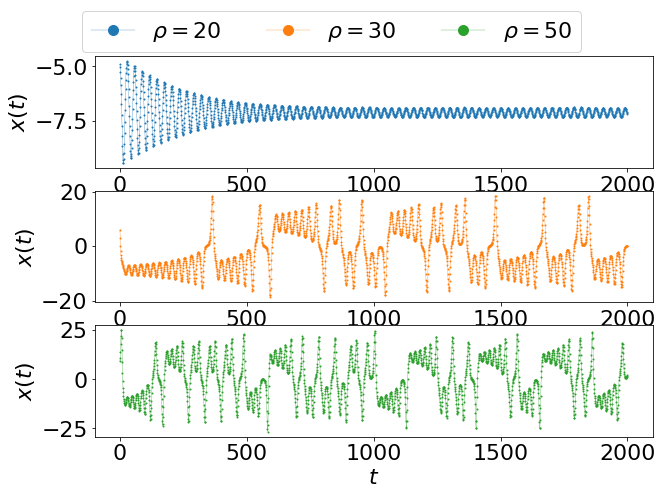

In [102]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 22})
rv = [20,30,50]
ii = 0
fig, ax = plt.subplots(3,1, figsize=(10,7))
colors = ['C0', 'C1', 'C2', 'C3']
for ii, r in enumerate(rv):
    ax[ii].plot(np.load(f"/scratch/scarpolini/databases/db_lorenz_{r:.1f}.npy")[0,0,:], label='$\\rho=$'+str(r), alpha=1, marker='.', lw=0.3, ms=2, color=colors[ii])
    ax[ii].set_ylabel('$x(t)$')

ax[2].set_xlabel('$t$')
fig.legend(markerscale=10,ncol=3,loc='upper center')
fig.savefig('plots/solutions',fmt='png',dpi=100)

# Analisi singoli Layer

In [108]:
rv = [10]
db, labels = load_and_shuffle_dbs(rv)
#labels = norm_labels(labels)
db10 = preprocess(db)
rv = [60]
db, labels = load_and_shuffle_dbs(rv)
db60 = preprocess(db)

In [109]:
weights = desc.get_weights()
for i in range(len(weights)): 
    print( weights[i].shape, weights[i].mean(), weights[i].std() )

(20, 1, 16) -0.0020141634 0.022242347
(16,) 0.0057628807 0.018311165
(20, 16, 16) 0.013437942 0.030359989
(16,) -0.005799745 0.004980472
(20, 16, 16) 0.012991661 0.03451685
(16,) -0.006199533 0.0082199145
(128, 128) 0.0029911576 0.0946826
(128,) -0.0017243931 0.017030355
(128, 1) -0.004443762 0.16748941
(1,) 0.0010479864 0.0


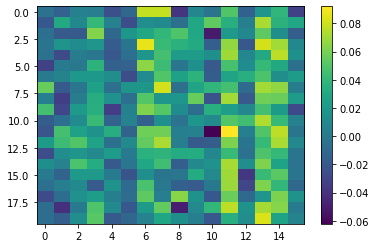

In [110]:
import matplotlib.pyplot as plt
plt.imshow(weights[2][:,:,15].reshape(20,-1), aspect="auto")
plt.colorbar()

In [111]:
from tensorflow.keras import backend as K

inp = desc.input                                           # input placeholder
outputs = [layer.output for layer in desc.layers]          # all layer outputs
functor = K.function([inp], outputs )   # evaluation function

# Testing
layer_outs10 = functor(db10[4:5])
layer_outs60 = functor(db60[4:5])

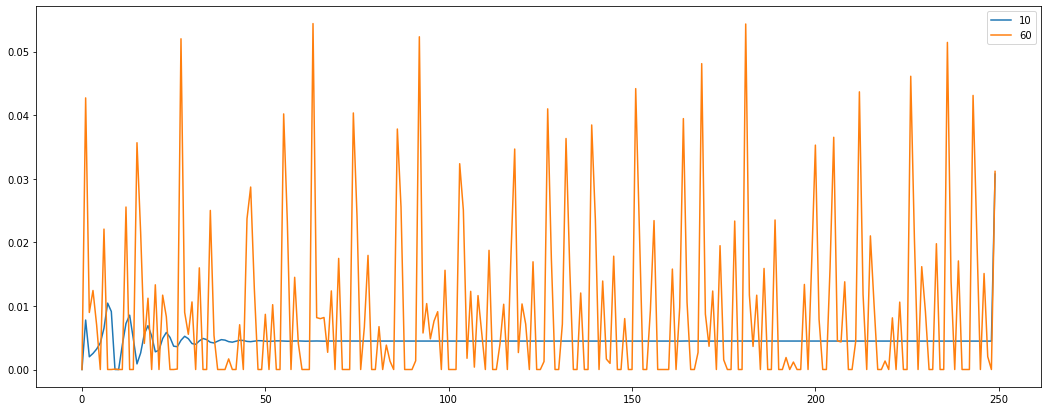

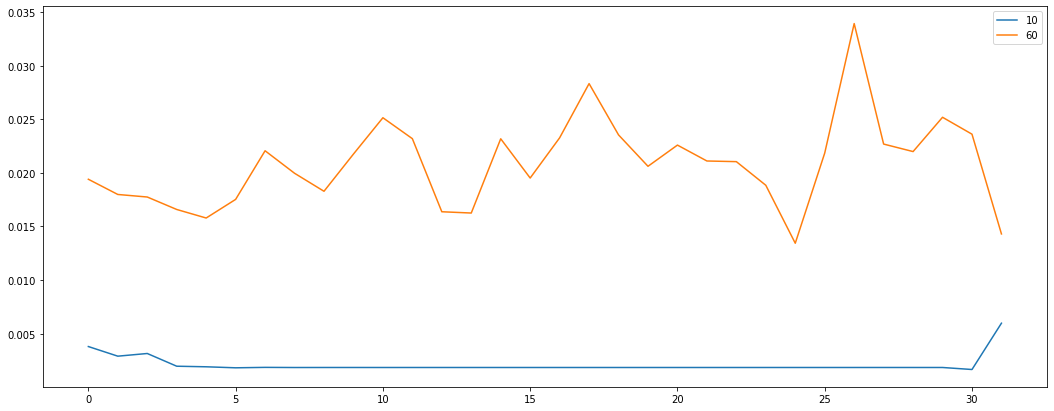

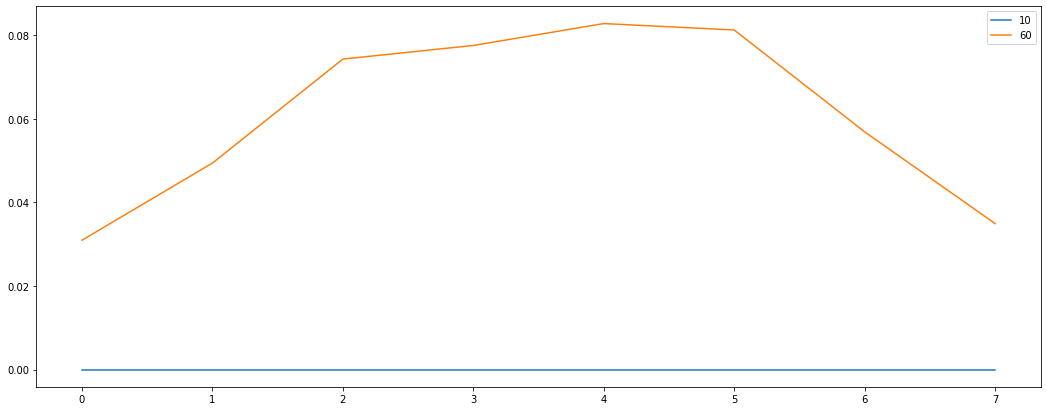

In [120]:
for ii in range(3):
    temp10 = layer_outs10[ii]
    temp60 = layer_outs60[ii]
    dim2000, dim_features = temp10.shape[1],temp10.shape[2]
    #dim2000, dim_features = temp.shape[0],temp.shape[1]
    temp10 = temp10.reshape(dim2000, dim_features)
    temp60 = temp60.reshape(dim2000, dim_features)
    import matplotlib.pyplot as plt
    #plt.imshow(temp, aspect="auto")
    #plt.colorbar()
    #plt.show()
    plt.figure(figsize=(18,7))
    plt.plot(temp10[:,0],label=10)
    plt.plot(temp60[:,0],label=60)
    plt.legend()
    plt.show()